## Fetch the Data and Visualize Data

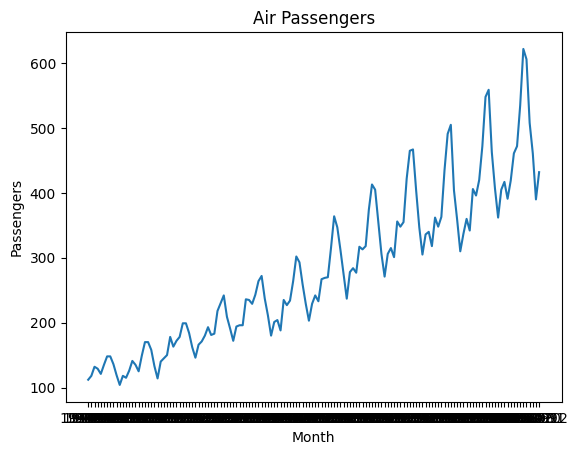

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Fetch Data
data = pd.read_csv('data-sets/air_passengers.csv')

month = data['Month']
passengers = data['Passengers']

# Data has a datetime column, set it as the index
data['Month'] = pd.to_datetime(data['Month'])
data.set_index('Month', inplace=True)


plt.plot(month, passengers)
plt.xlabel('Month')
plt.ylabel('Passengers')
plt.title('Air Passengers')
plt.show()

<Axes: xlabel='Month'>

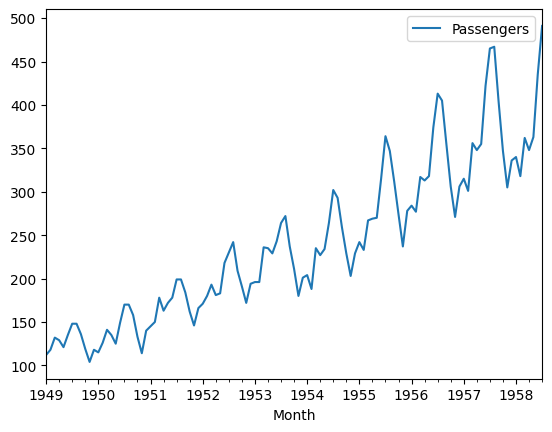

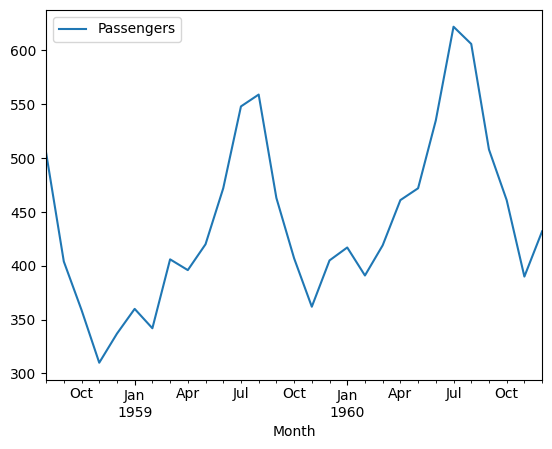

In [2]:
train_size = int(len(data) * 0.80)
test_size = int(len(data) * 0.20)


train_data = data[:train_size]
test_data = data[train_size:]

train_data.plot()
test_data.plot()

## Clean trend and seasonality from data

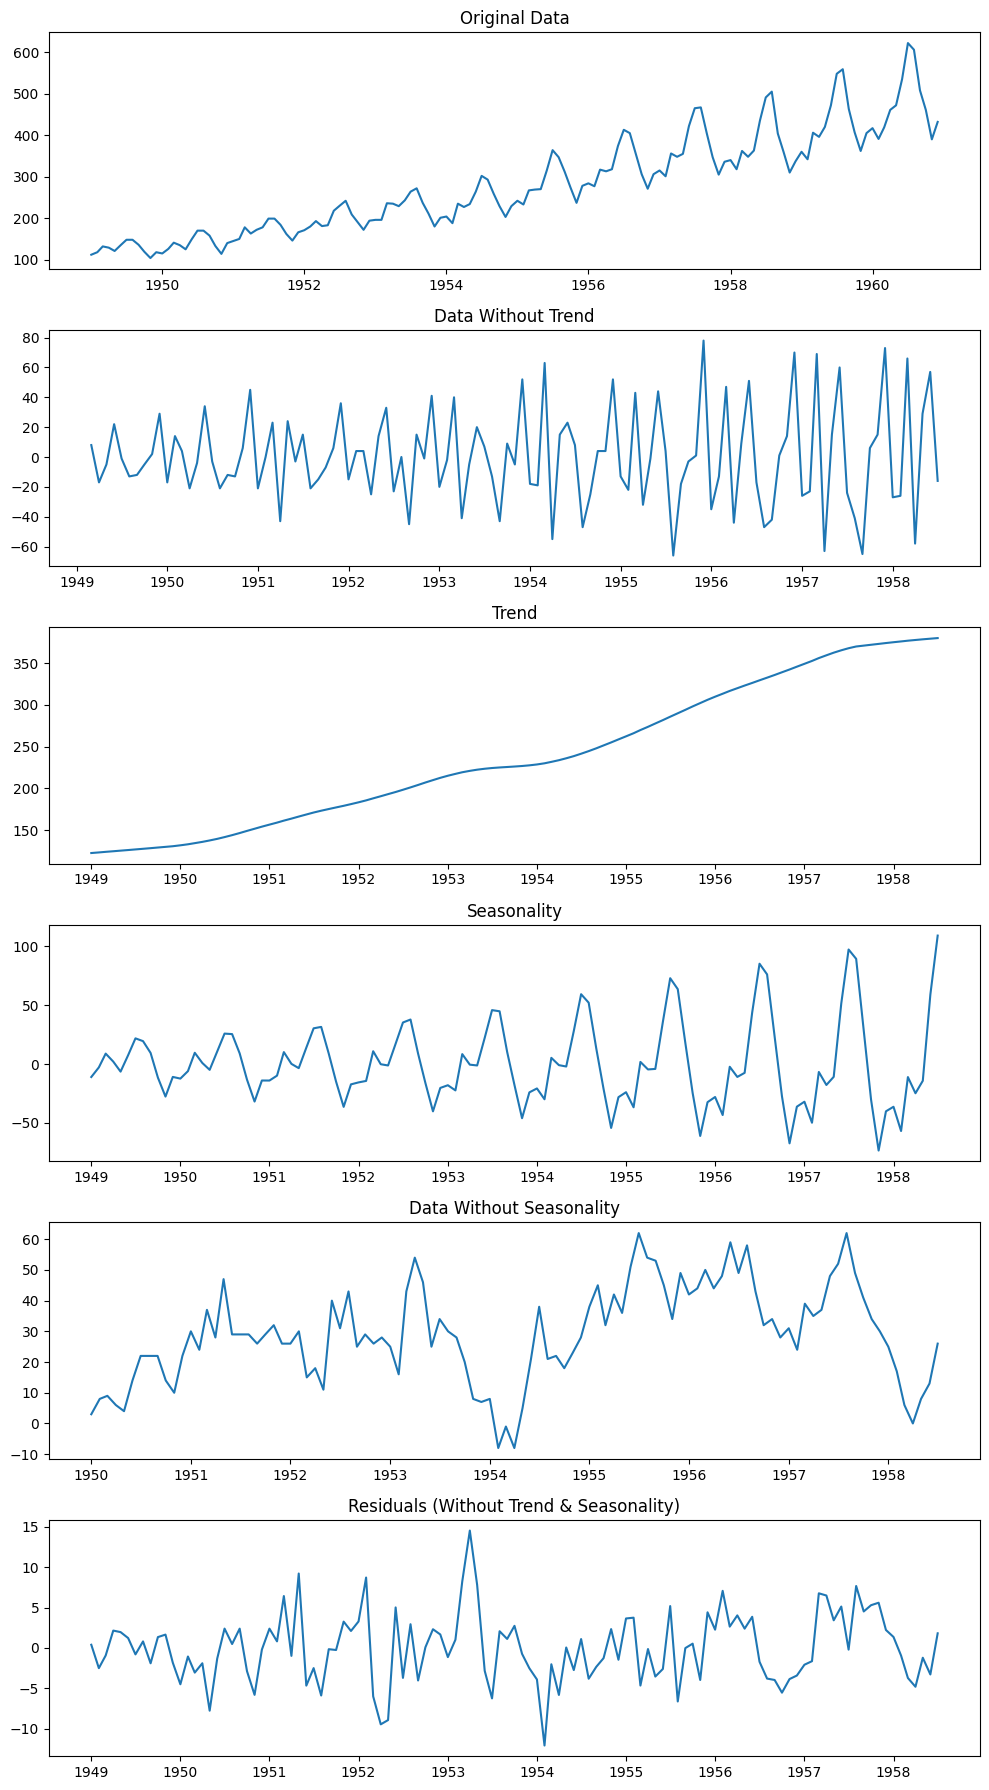

In [3]:
from statsmodels.tsa.seasonal import STL


# Perform seasonal decomposition
decomp = STL(train_data).fit()

# Obtain the trend, seasonal, and residual components

# d = 2
data_without_trend = train_data['Passengers'].diff().diff()
trend = decomp.trend


# seasonality = 12
seasonal_period = 12
data_without_seasonality = train_data['Passengers'].diff(periods=seasonal_period)
seasonal = decomp.seasonal

residuals = decomp.resid
residuals_df = pd.DataFrame({'residuals': residuals})

# p = 2
residuals_df['t-1'] = residuals_df['residuals'].shift(1).values
residuals_df['t-2'] = residuals_df['residuals'].shift(2).values
residuals_df = residuals_df.dropna()

# Plot the original data, trend, and seasonality
plt.figure(figsize=(10, 18))

plt.subplot(6, 1, 1)
plt.plot(data)
plt.title('Original Data')

plt.subplot(6, 1, 2)
plt.plot(data_without_trend)
plt.title('Data Without Trend')

plt.subplot(6, 1, 3)
plt.plot(trend)
plt.title('Trend')

plt.subplot(6, 1, 4)
plt.plot(seasonal)
plt.title('Seasonality')

plt.subplot(6, 1, 5)
plt.plot(data_without_seasonality)
plt.title('Data Without Seasonality')

plt.subplot(6, 1, 6)
plt.plot(residuals)
plt.title('Residuals (Without Trend & Seasonality)')

plt.tight_layout()
plt.show()

## We will continue with the residuals data

In [4]:
import numpy as np
import statsmodels.api as sm
import pandas as pd

data = data.reset_index(drop=True)
residuals_df = residuals_df.reset_index(drop=True)

In [5]:
from sklearn import svm

X_train = residuals_df[['t-1', 't-2']]
y_train = residuals_df['residuals']

model = svm.SVR()
test_data.head()


,Passengers
Month,
1958-08-01,505
1958-09-01,404
1958-10-01,359
1958-11-01,310
1958-12-01,337


BayesSearch

In [6]:
from sklearn.model_selection import KFold
from skopt import BayesSearchCV
from skopt.plots import plot_objective, plot_histogram
import skopt

# Decleartions for deprecated functions in numpy
np.float = float    
np.int = int    
np.object = object    
np.bool = bool    

# Define hyperparameters for bayesian optimization
param_space = {
    'kernel': ['rbf', 'sigmoid', 'poly', 'linear'],
    'C': (1e-6, 1e+1, 'log-uniform'),
    'gamma': (1e-6, 1e+1, 'log-uniform'),
    'epsilon': (1e-6, 1e+6, 'log-uniform')
    }


kFold = KFold(n_splits=10, shuffle=True, random_state=10)

bayes_search = BayesSearchCV(estimator=model, search_spaces=param_space, cv= kFold, n_jobs=-1, 
                             scoring='neg_mean_absolute_percentage_error', n_iter=10)

bayes_search.fit(X_train, y_train)

# Print the cross validation results
cv_results = bayes_search.cv_results_
cv_results_df = pd.DataFrame(cv_results)

cv_results_df['kernel'] = cv_results_df['params'].apply(lambda x: x['kernel'])
cv_results_df['C'] = cv_results_df['params'].apply(lambda x: x['C'])
cv_results_df['gamma'] = cv_results_df['params'].apply(lambda x: x['gamma'])
cv_results_df['epsilon'] = cv_results_df['params'].apply(lambda x: x['epsilon'])


print(cv_results_df[['mean_test_score', 'kernel', 'C', 'gamma', 'epsilon']])

# plot_objective creates pairwise dependence plot of the objective function.
# plot_objective(bayes_search.optimizer_results_[0],
#                    dimensions=["C", "gamma", "epsilon"],
#                    n_minimum_search=int(1e8))

# Print the best hyperparameters
print('Best hyperparameters:', bayes_search.best_params_)

best_model = bayes_search.best_estimator_


   mean_test_score   kernel         C     gamma   epsilon
0        -1.688450   linear  0.009169  0.023306  0.000442
1        -1.196753     poly  0.002882  0.000593  0.435674
2        -1.189911  sigmoid  0.214743  0.000068  0.000011
3        -1.540396     poly  0.000008  0.451030  0.266223
4        -1.710282     poly  0.202456  2.274329  7.809188
5        -1.237111   linear  0.000752  0.723064  1.625379
6        -2.854309     poly  0.000236  9.418593  0.000001
7        -1.188687      rbf  0.041464  0.000562  0.001004
8        -1.162099     poly  0.799605  0.000001  0.732835
9        -1.192222      rbf  0.001991  0.000063  0.001810
Best hyperparameters: OrderedDict([('C', 0.7996054119140249), ('epsilon', 0.7328352543519656), ('gamma', 1.1409498610625753e-06), ('kernel', 'poly')])


In [7]:
import matplotlib.pyplot as plt

test_data['t-1'] = test_data.shift(1).values
test_data['t-2'] = test_data.shift(2).values

X_test = test_data[['t-1', 't-2']]

y_test = test_data['Passengers']


best_model.fit(X_train, y_train)
y_pred_resid = best_model.predict(X_test)


print(y_pred_resid - y_test)

ValueError: Expected a 1D array, got an array with shape (29, 2)

In [ ]:
# Our seasonality is yearly (12 months)
seasonal_period = 12 

# Extend the last known value of the trend into the future.
last_known_trend = trend[-seasonal_period:].mean()

# trend_test = np.full(len(X_test), last_known_trend)

# Repeat the last complete seasonal cycle for future periods.
last_seasonal_cycle = seasonal[-seasonal_period:]
seasonal_test = np.tile(last_seasonal_cycle, len(X_test) // seasonal_period + 1)[:len(X_test)]


# Add back the trend and seasonal components.
y_pred = y_pred_resid + last_known_trend + seasonal_test
y_test = y_test + last_known_trend + seasonal_test 

# Plotting
plt.figure(figsize=(10,6))
plt.plot(y_test.index, y_test, label='Real')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

mse = mean_absolute_percentage_error(y_test, y_pred)
print('Mean Squared Error on test set:', mse)